Model Directory: m2_00_global_2000_2018_band29

### Loss Information from Tensorboard

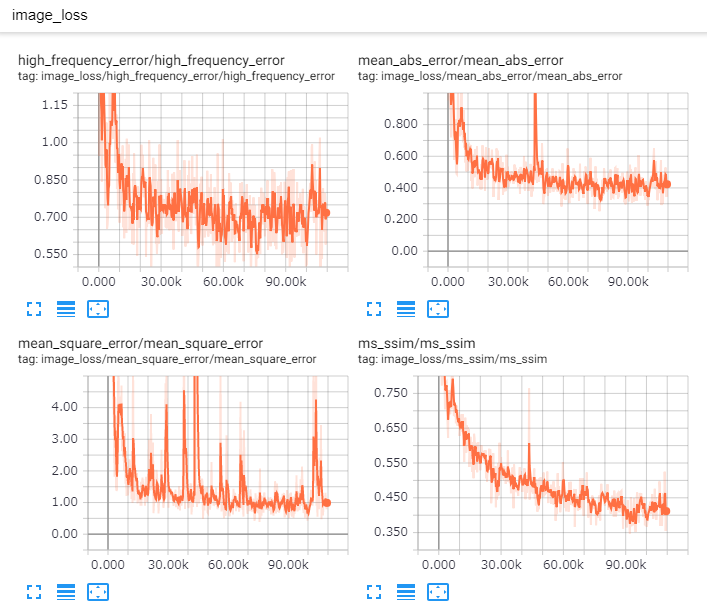

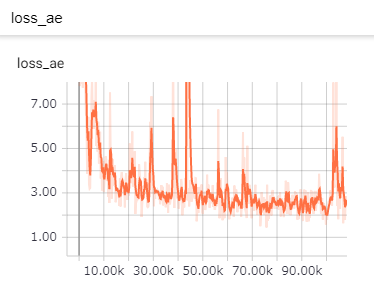

In [2]:
import os
import glob
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [6]:
sys.path.insert(1,os.path.join(sys.path[0],"/home/tkurihana/scratch-midway2/data/MOD02"))
from lib_modis02 import load_tfrecord, _get_imgs,  _get_num_imgs

In [27]:
sys.path.insert(1, os.path.join(sys.path[0],"/home/tkurihana/scratch-midway2/data/MOD06/" ) )
from analysis_lib import _get_colors, _gen_patches, _anl_agl
from analysis_lib import cluster_plotting2, cluster_plotting

In [29]:
from pyhdf.SD import SD, SDC

In [66]:
from sklearn.cluster import AgglomerativeClustering

In [102]:
from matplotlib import patches as mpl_patches

### Load model

In [1]:
datadir = "/project2/foster/clouds/output/mod02/m2_00_global_2000_2018_band29"

In [3]:
step = 100000

In [4]:
encoder_def = datadir+'/encoder.json'
encoder_weight = datadir+'/encoder-'+str(step)+'.h5'
with open(encoder_def, "r") as f:
    encoder = tf.keras.models.model_from_json(f.read())
encoder.load_weights(encoder_weight)

/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:791: UserWarning: models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


In [5]:
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 128, 128, 4)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 592         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 16)   2320        leaky_re_lu[0][0]                
__________________________________________________________________________________________________
leaky_re_l

In [16]:
decoder_def = datadir+'/decoder.json'
decoder_weight = datadir+'/decoder-'+str(step)+'.h5'
with open(decoder_def, "r") as f:
    decoder = tf.keras.models.model_from_json(f.read())
decoder.load_weights(decoder_weight)

/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:791: UserWarning: models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


In [17]:
decoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      (None, 8, 8, 128)    0                                            
__________________________________________________________________________________________________
leaky_re_lu_8 (LeakyReLU)       (None, 8, 8, 128)    0           decoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_transpose (Conv2DTranspo (None, 16, 16, 128)  147584      leaky_re_lu_8[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 16, 16, 128)  0           conv2d_transpose[0][0]           
__________________________________________________________________________________________________
conv2d_9 (

### Load test data
clouds_laads_preprocessed_2000_2018_band29_test \<br \>
1. 0-0.tfrecord  
2. 0-1.tfrecord

In [7]:
mod_datadir = "/home/tkurihana/scratch-midway2/data/MOD02/clouds_laads_preprocessed_2000_2018_band29_test"
filelist = glob.glob(mod_datadir+'/*')
filelist

['/home/tkurihana/scratch-midway2/data/MOD02/clouds_laads_preprocessed_2000_2018_band29_test/0-1.tfrecord',
 '/home/tkurihana/scratch-midway2/data/MOD02/clouds_laads_preprocessed_2000_2018_band29_test/0-0.tfrecord']

In [8]:
nfiles = []
for ifile in filelist:
    nfiles += [_get_num_imgs(ifile)]
nfiles

[90, 100]

In [11]:
load_data = (load_tfrecord(filelist[0], (128,128,4)))
imgs, coords, names = _get_imgs(load_data, n=nfiles[0])

Instructions for updating:
Use `tf.data.experimental.parallel_interleave(...)`.
Tensor("ParseSingleExample/ParseSingleExample:1", shape=(), dtype=string) Tensor("ParseSingleExample/ParseSingleExample:0", shape=(2,), dtype=int64) Tensor("random_crop:0", shape=(128, 128, 4), dtype=float64)
<ParallelInterleaveDataset shapes: ((), (2,), (128, 128, 4)), types: (tf.string, tf.int64, tf.float64)>
Instructions for updating:
Use `tf.data.Dataset.batch(..., drop_remainder=True)`.


In [12]:
imgs.shape

(90, 128, 128, 4)

#### Check image

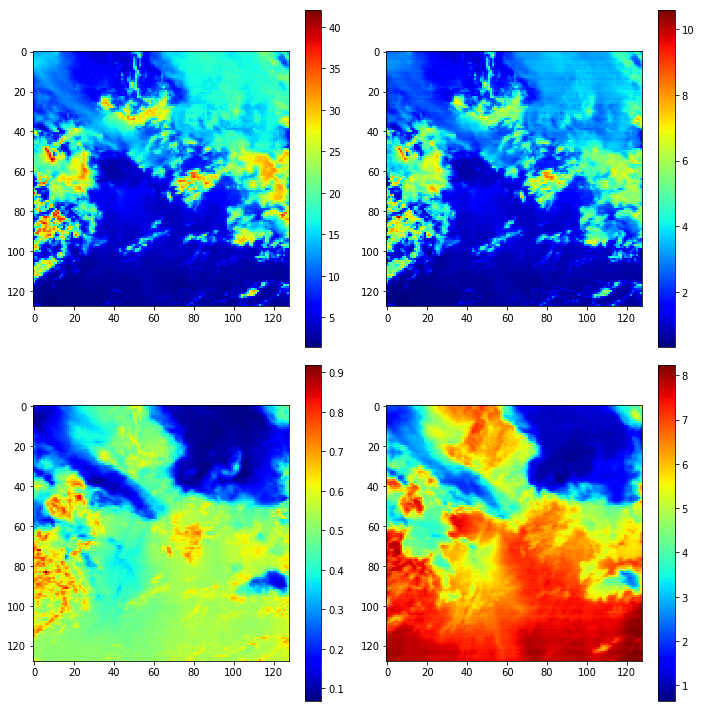

In [14]:
tmp_img = imgs[30]
fig = plt.figure(figsize=(10,10))
for idx, i in enumerate(range(4)):
    ax = plt.subplot(2,2,idx+1)
    plt.imshow(tmp_img[:,:,i], cmap='jet')
    plt.colorbar()
fig.tight_layout()
plt.show()

### Construction 

In [18]:
encoded_img = encoder.predict(imgs)

In [19]:
decoded_img = decoder.predict(encoded_img)

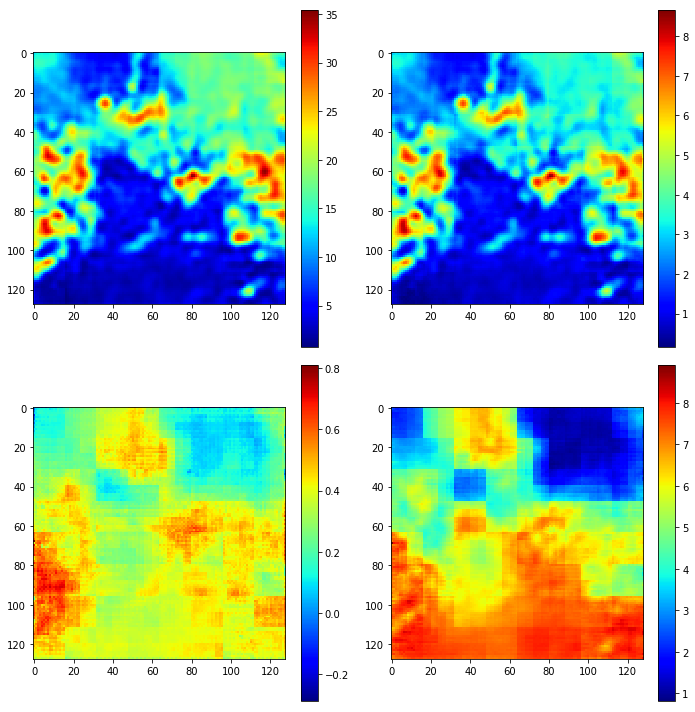

In [21]:
tmp_decod = decoded_img[30]
fig = plt.figure(figsize=(10,10))
for idx, i in enumerate(range(4)):
    ax = plt.subplot(2,2,idx+1)
    plt.imshow(tmp_decod[:,:,i], cmap='jet')
    plt.colorbar()
fig.tight_layout()
plt.show()

In [24]:
res = imgs - decoded_img

In [25]:
tmp_res = res[30]
fig = plt.figure(figsize=(10,10))
for idx, i in enumerate(range(4)):
    ax = plt.subplot(2,2,idx+1)
    plt.imshow(tmp_res[:,:,i], cmap='jet')
    plt.colorbar()
fig.tight_layout()
plt.show()

### Clustering example on a coast of new-zealand

In [28]:
hdf_datadir = "/project2/chard/clouds/data/MOD02/04"

- Band 6: MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_500_Aggr1km_RefSB_4.hdf
- Band 7: MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_500_Aggr1km_RefSB_5.hdf
- Band 20:MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_1KM_Emissive_1.hdf 
- Band 29:MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_1KM_Emissive_9.hdf

In [51]:
hdf_filelist=[
    hdf_datadir+'/MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_500_Aggr1km_RefSB_4.hdf',
    hdf_datadir+'/MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_500_Aggr1km_RefSB_5.hdf',
    hdf_datadir+'/MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_1KM_Emissive_1.hdf',
    hdf_datadir+'/MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_1KM_Emissive_9.hdf'
]

checkio

In [41]:
hdf = SD(hdf_datadir+"/MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_500_Aggr1km_RefSB_4.hdf",
        SDC.READ)

In [42]:
hdf.datasets()

{'EV_500_Aggr1km_RefSB': (('YDim:MODIS_SWATH_Type_L1B',
   'XDim:MODIS_SWATH_Type_L1B'),
  (4513, 4748),
  23,
  0)}

In [44]:
hdf_sds = hdf.select('EV_500_Aggr1km_RefSB')
hdf_sds.attributes()

{'long_name': 'Earth View 500M Aggregated 1km Reflective Solar Bands Scaled Integers',
 'units': 'none',
 'valid_range': [0, 32767],
 '_FillValue': 65535,
 'band_names': '6',
 'radiance_scales': 0.0027236402966082096,
 'radiance_offsets': -0.0,
 'radiance_units': 'Watts/m^2/micrometer/steradian',
 'reflectance_scales': 3.680860754684545e-05,
 'reflectance_offsets': -0.0,
 'reflectance_units': 'none',
 'corrected_counts_scales': 0.12497329711914062,
 'corrected_counts_offsets': -0.0,
 'corrected_counts_units': 'counts'}

#### functions

In [46]:
def proc_sds(sds_array):
    """
    IN: array = hdf_data.select(variable_name)
    """
    array = sds_array.get()
    array = array.astype(np.float64)
    
    # check bandinfo
    _bands = sds_array.attributes()['band_names']
    print("Process bands", _bands)
    bands = _bands.split(",")
    
    # nan process
    nan_idx = np.where( array == sds_array.attributes()['_FillValue'])
    if len(nan_idx) > 0:
        array[nan_idx] = np.nan
    else:
        pass
    
    # radiacne offset
    offset = sds_array.attributes()['radiance_offsets']
    offset_array = np.zeros(array.shape) # new matrix
    offset_ones  = np.ones(array.shape)  # 1 Matrix 
    offset_array[:,:] = array[:,:] - offset*offset_ones[:,:]
    
    # radiance scale
    scales = sds_array.attributes()['radiance_scales']
    scales_array = np.zeros(array.shape) # new matrix
    scales_array[:,:] = scales*offset_array[:,:]
    return scales_array, bands

In [54]:
b6_hdf = SD(hdf_filelist[0], SDC.READ)
b7_hdf = SD(hdf_filelist[1], SDC.READ)
b20_hdf = SD(hdf_filelist[2], SDC.READ)
b29_hdf = SD(hdf_filelist[3], SDC.READ)

In [55]:
b6_sds = b6_hdf.select("EV_500_Aggr1km_RefSB")
b7_sds = b7_hdf.select("EV_500_Aggr1km_RefSB")
b20_sds = b20_hdf.select("EV_1KM_Emissive")
b29_sds = b29_hdf.select("EV_1KM_Emissive")

In [57]:
b6_array, b6 = proc_sds(b6_sds)
b7_array, b7 = proc_sds(b7_sds)
b20_array, b20 = proc_sds(b20_sds)
b29_array, b29 = proc_sds(b29_sds)

Process bands 6
Process bands 7
Process bands 20
Process bands 29


In [59]:
nx, ny = b6_array.shape

In [60]:
d_list = [
    b6_array.reshape(nx,ny,1),
    b7_array.reshape(nx,ny,1),
    b20_array.reshape(nx,ny,1),
    b29_array.reshape(nx,ny,1),
]

In [61]:
mod02_img = np.concatenate(d_list, axis=2)

In [62]:
mod02_img.shape

(4513, 4748, 4)

In [63]:
fig = plt.figure(figsize=(12,12))
for idx, i in enumerate(range(4)):
    ax = plt.subplot(2,2,idx+1)
    plt.imshow(mod02_img[:,:,i], cmap='jet')
    plt.colorbar()
fig.tight_layout()
plt.show()

### Clustering bottleneck layer

In [72]:
def const_array(patches):
    nx, ny = patches.shape[:2]
    patches_list = []
    xy_list = []
    for i in range(nx):
        for j in range(ny):
            if not np.isnan(patches[i,j]).any():
                patches_list += [patches[i,j]]
                xy_list += [(i,j)]
    return patches_list, xy_list

In [ ]:
def anl_agl(encoder, patches, clusters=icluster, nband=4):
    

In [69]:
patches = _gen_patches(mod02_img, normalization=False)
patches.shape

(35, 37, 128, 128, 4)

In [73]:
patches_list, xy_list = const_array(patches)

In [81]:
encs_list = []
for i in patches_list:
    encs = encoder.predict(i.reshape(1,128,128,4))
    encs_list += [encs.mean(axis=(1,2))]

In [87]:
features = np.concatenate(encs_list, axis=0)

In [88]:
features.shape

(1009, 128)

In [82]:
n_cluster = 10

In [89]:
method = AgglomerativeClustering(n_clusters=n_cluster)
_patches_labels = method.fit_predict(features)

In [97]:
ix, iy = patches.shape[:2]

In [98]:
img_array = np.zeros((ix,iy)).astype(np.float64)
img_array[:,:] = np.nan
for idx, (x,y) in enumerate(xy_list):
    img_array[x,y] = _patches_labels[idx]

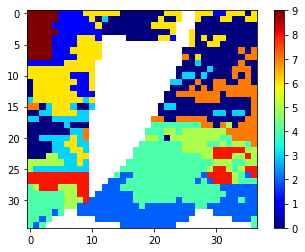

In [100]:
plt.imshow(img_array, cmap='jet')
plt.colorbar()

### Align to each image

In [105]:
fig = plt.figure(figsize=(12,12))

line_width = 2
SHAPE = 128,128
colors = _get_colors(n=n_cluster)
for idx, i in enumerate(range(4)):
    ax = plt.subplot(2,2,idx+1)
    plt.imshow(mod02_img[:,:,i], cmap='bone')
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            if not np.isnan(img_array[i,j]):
                ax.add_patch(mpl_patches.Rectangle(
                      (j * SHAPE[0] + line_width , i * SHAPE[1] + line_width ),
                      width=SHAPE[0] - line_width * 2,
                      height=SHAPE[1] - line_width * 2,
                      linewidth=1,
                      edgecolor=colors[int(img_array[i,j])],
                      facecolor="none"                 
                      ))
fig.tight_layout()
plt.show()

### Align to visible image

In [106]:
vis_file = hdf_datadir+'/MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_250_Aggr1km_RefSB_1.hdf'

In [107]:
vhdf = SD(vis_file, SDC.READ)

In [108]:
vhdf_sds = vhdf.select("EV_250_Aggr1km_RefSB")

In [109]:
vhdf_sds.attributes()

{'long_name': 'Earth View 250M Aggregated 1km Reflective Solar Bands Scaled Integers',
 'units': 'none',
 'valid_range': [0, 32767],
 '_FillValue': 65535,
 'band_names': '1',
 'radiance_scales': 0.028091058135032654,
 'radiance_offsets': -0.0,
 'radiance_units': 'Watts/m^2/micrometer/steradian',
 'reflectance_scales': 5.678103843820281e-05,
 'reflectance_offsets': -0.0,
 'reflectance_units': 'none',
 'corrected_counts_scales': 0.12497329711914062,
 'corrected_counts_offsets': -0.0,
 'corrected_counts_units': 'counts'}

In [110]:
vhdf_array, vis_band = proc_sds(vhdf_sds)

Process bands 1


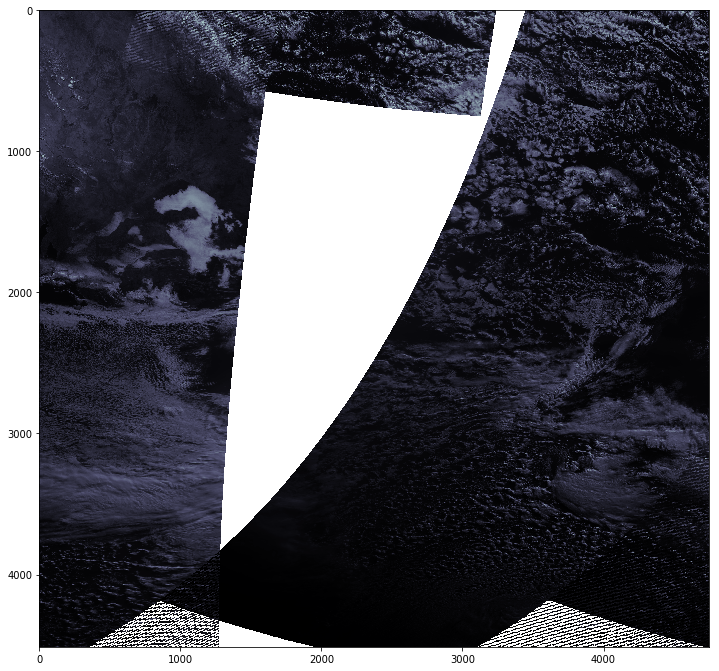

In [112]:
plt.figure(figsize=(12,12))
plt.imshow(vhdf_array, cmap='bone')

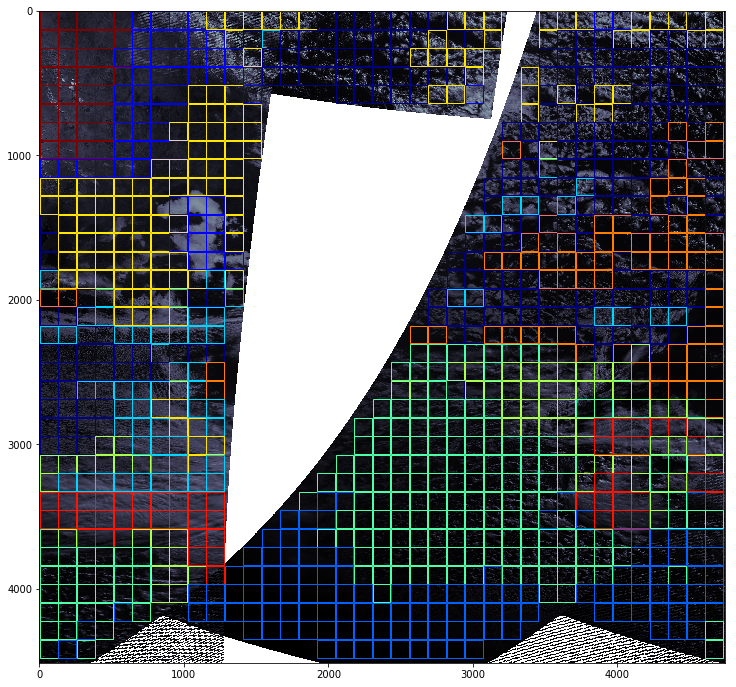

In [115]:
fig = plt.figure(figsize=(20,20))

line_width = 2
SHAPE = 128,128
colors = _get_colors(n=n_cluster)
for idx, i in enumerate(range(1)):
    ax = plt.subplot(2,2,idx+1)
    plt.imshow(vhdf_array, cmap='bone')
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            if not np.isnan(img_array[i,j]):
                ax.add_patch(mpl_patches.Rectangle(
                      (j * SHAPE[0] + line_width , i * SHAPE[1] + line_width ),
                      width=SHAPE[0] - line_width * 2,
                      height=SHAPE[1] - line_width * 2,
                      linewidth=1,
                      edgecolor=colors[int(img_array[i,j])],
                      facecolor="none"                 
                      ))
fig.tight_layout()
plt.show()

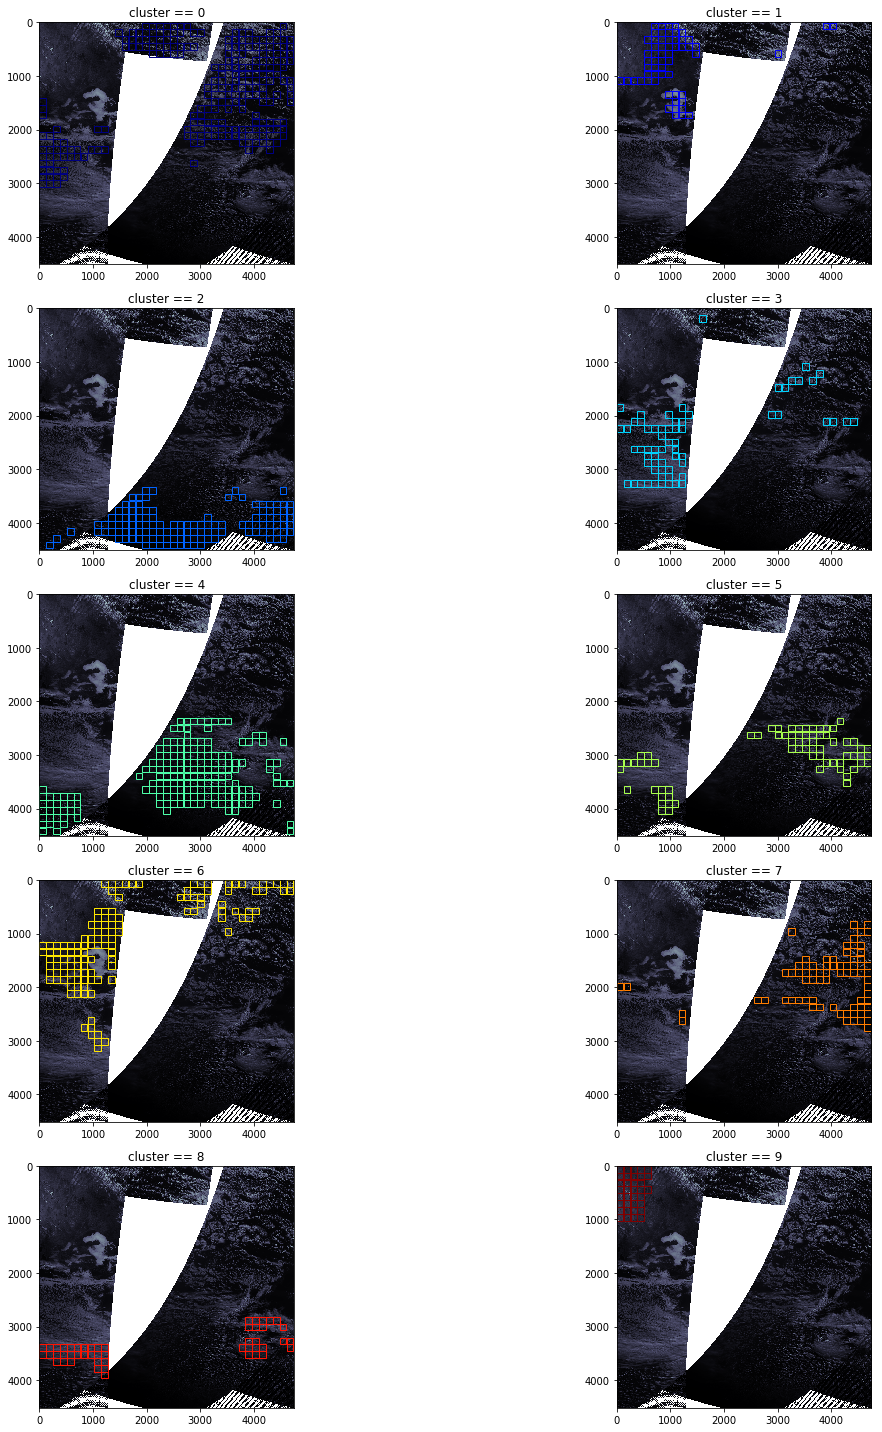

In [118]:
fig = plt.figure(figsize=(20,20))

line_width = 2
SHAPE = 128,128
colors = _get_colors(n=n_cluster)
for idx, icluster in enumerate(range(10)):
    ax = plt.subplot(5,2,idx+1)
    plt.imshow(vhdf_array, cmap='bone')
    ax.set_title("cluster == %d" % idx)
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            if not np.isnan(img_array[i,j]):
                if img_array[i,j] == icluster:
                    ax.add_patch(mpl_patches.Rectangle(
                      (j * SHAPE[0] + line_width , i * SHAPE[1] + line_width ),
                      width=SHAPE[0] - line_width * 2,
                      height=SHAPE[1] - line_width * 2,
                      linewidth=1,
                      edgecolor=colors[int(img_array[i,j])],
                      facecolor="none"                 
                      ))
fig.tight_layout()
plt.show()